## Load Image
This notebook presents the critical (specific) functions used in CoastSnap to load an image to be analysed.

In [1]:
%alter the path in the add path function to match your own
addpath('/Users/nickheaney/Desktop/Jupyter notebooks/final releases/MATLAB Notebooks')
addpath('/Users/nickheaney/Desktop/CoastSnap/Code/GUI')
load('load_Image.mat');

### 1. Clear current figures and data.
### 2. Get the image's "navigation" info if the image has already, previously been loaded.
### 3. Prompt the user to select the processed image.

***uigetfile*** is used to enable file selection. This function enables the specification of the path of the folder containing the images. This is where the user is directed to in the UI. ***uigetfile*** returns the name of the file selected, **fname** and the path of this file **pname**.<br>
**NOTE IMPORTANT FOR TRANSLATION**: the data inside the square brackets specifies the required path and the file type to be listed. The other piece of data there: filesep is a general term for the file separator in the path. Since CoastSnap is designed to run on all operating systems, the general term is used (i.e. if instead of filesep, \ was used, this would only be valid for windows operating systems as apple and linux use /)

In [2]:
[fname,pname]=uigetfile([data.path filesep '*.jpg'],'Select CoastSnap Image .jpg file from Processed Folder')


fname =

    '1495147020.Fri.May.19_08_37_00.AEST.2017.manly.snap.IanCoghlan.jpg'


pname =

    '/Users/nickheaney/Desktop/CoastSnap/Code/Images/manly/Processed/2017/'



### 4. Read and display the image file

The function ***fullfile*** concatenates the file name to the end of the path for ***imread*** to successfully loacte and read the image.

In [3]:
I = imread(fullfile(pname,fname)); %Read image

Display the image using ***imagesc***

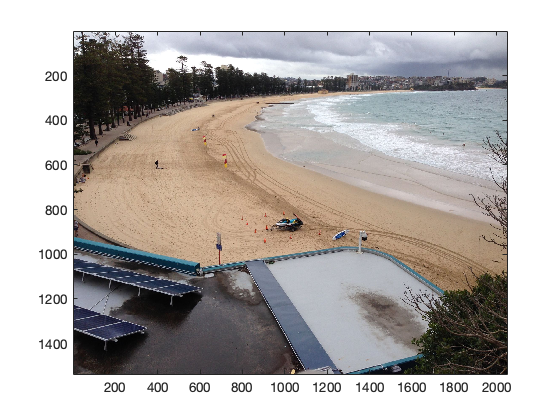

In [4]:
imagesc(I)

### 5. Check if the image has already been rectified

To do this, CoastSnap uses ***strrep*** to take the path to the file of the currently displayed "Processed" image and alters it to the file path of what would be the corresponding "Rectified" image if it exists (i.e. it replaces the 'Precessed' folder with the 'Rectified' folder in the image path:

In [5]:
rect_path = strrep(pname,'Processed','Rectified');

**Note:** It can be seen in the matlab code that below the above line, the following line exists:

In [6]:
rect_path = strrep(rect_path,'Registered','Rectified'); %For Registered images <br>

**Note continued:** The reason for this is for the case of a registered image (as detailed), it does not affect the already created **rect_path** because if 'Registered' does not exist in the string, then the string is not updated. This is the same situation when defining the would-be rectified image file name, **rect_name** below (but in this case for timex images):

In [7]:
rect_name = strrep(fname,'snap','plan'); %Rectified is called plan to keep with Argus conventions
rect_name = strrep(rect_name,'timex','plan'); %For timex images

Finally, the ***exist*** function is used to check if the file exists and hence, the file has previously been rectified:

In [8]:
exist(fullfile(rect_path,rect_name),'file')


ans =

     2



**Note:** This is not a simple Boolean operator, there are many possible outputs: the output of 2 from this function indicates that the input is an existing file. 0 would indicate that it does not exist, while 1 would indicate that the input is a variable in the MATLAB workspace (not applicable to our use).

This ***exist*** function is used as the condition for the if loop which goes on to display the previously rectified image (if it already exists).

### 6. Check if the image has already been shoreline mapped

Extract data contained in the file name using ***CSPparseFilename*** (eg time, timezone, site, user etc...) these are assigned to a structure using simple indexing.

In [9]:
imdata = CSPparseFilename(fname);

From hereon, the same method as for checking if the image is already rectified is used (the same functions), however there is one thing to note:

**Note:** in the cell below, the string, shoreline_path, exists from the previous running of the ***CSPloadPaths*** function (near the beginning of ***CSPGloadImage***).

In [10]:
CSPloadPaths %%%from earlier in function's code
sldir = fullfile(shoreline_path,imdata.site,imdata.year);

### 7. Extract data from the site's database (Excel spreadsheet)

The site name is taken from the **imdata** variable structure (generated above):

In [11]:
data.site = imdata.site; %imdata has been created already from the file name information (see 2 cells up).
site = data.site;

***CSPreadSiteDB*** reads the excel database and converts its information into a MATLAB structure using the following critical functions:

***xlsread*** extracts the excel data:

In [12]:
dbfile = fullfile([DB_path filesep 'CoastSnapDB.xlsx']);
[data1, txt, raw] = xlsread(dbfile,site); %note, I have used 'data1', while thee original code uses data, this isjust to keep this notebook operating smoothly

***strcmp*** is a Boolean operator to compare strings. In the case below is is used to locate the CoastSnap Station information (Station Data) cells extracted from the excel database:

In [13]:
%Read station origin
I = find(strcmp(raw(:,1),'Station Data'));
out.origin.eastings = cell2mat(raw(I+1,2)); %Origin eastings should be first row after Station Data

Above ***cell2mat*** converts the cell to a number.

Below, ***strcmp*** is used again to locate the relevant cells, this time for 'UTM Zone'. However, this time, instead of using ***cell2mat*** to place this information into the MATLAB structure, ***char*** is used. This converts the cell to a character array:

In [14]:
I = find(strcmp(raw(:,1),'UTM Zone'));
out.UTMzone = char(raw(I,2));

The remainder of the information is assigned to the MATLAB structure using a similar procedure (the same functions).

In [15]:
siteDB = CSPreadSiteDB(site);

### 8. Get the tide level for the loaded image

Firstly, the tide level is extracted using ***CSPgetTideLevel***. <br>
***CSPgetTideLevel*** firstly identifies the name of the tide .mat file (generated from ***CSPreadSiteDB***) and adds it to the end of the path to the folder containing it so that the .mat file can then be loaded. The .mat file containing the tide information includes: times and corresponding tide levels, timezone and datum.

In [16]:
%Defining epochtime to run the following cell smoothly
data.epoch = str2num(imdata.epochtime);

In [17]:
%first load the tide information file (as described above)
load([tide_path filesep siteDB.tide.file])
%setting the time to local time (epoch2Matlab operates a simple multiplication)
matlabtimelocal = epoch2Matlab(imdata.epochtime)+siteDB.timezone.gmt_offset/24;

The tide at a particular time is found by interpolating between the values stated. This is done using ***interp1***

In [18]:
tide = interp1(tide.time,tide.level,matlabtimelocal);
%From within CSPGloadImage, CSPgetTideLevel is called simply using the following line:
tideZ = CSPgetTideLevel(str2num(imdata.epochtime),imdata.site);

After the tide level has been established and allocated to the variable **tideZ**, all images within the same tidal tolerance (+- 0.2m) are identified.

To do so, ***CSPgetImageList*** is used. It uses a for loop with the previously explored ***CSPparseFilename*** to extract the epoch times from each image's file name. ***CSPgetTideLevel*** is thereafter used again to determine the associated tide level for each image. <br>
**Note:** ***CSPgetImageList*** does not contain critical specialist functions so the internal code is not presented here:

In [23]:
%Some steps to enable the notebook to work (without reproducing the entire code):
data.tide_level = tideZ;
tide_tol = 0.2;
type = 'Processed';
% Now call CSPgetImageList:
[epochs_im,im_files,im_paths,im_tides]=CSPgetImageList(data.site,type);

Now find images with a similar tide level using conditional statement:

In [24]:
Iim = find(im_tides>(tideZ-tide_tol)&im_tides<(tideZ+tide_tol)); %find images within a similar tide level

Thereafter, the indices identified are used to determine the variables holding file names, paths, etc of the images within the tide range. These can then be accessed later. <br> e.g. :

In [25]:
navfiles = im_files(Iim);
navpaths = im_paths(Iim);

*This is the end of CSPGloadImage*